In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

from scipy.spatial import Voronoi, voronoi_plot_2d
import shapely

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


In [2]:
# --------------- PARAMETERS
# Cities (2020 unless running for 2010, then metro_gdf_2015?)
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'
# Year of analysis
year = '2020' # Currently works only for 2020, look for notes that say "Needs update for 'year' to work:"
# List of skip cities (If failed / want to skip city)
skip_city_list = []
# Hexgrid res of output
res_list = [8,9] #Only 8,9,10 and 11 available, will run 8 and 9 for prox. analysis v2.

# --------------- 

# --------------- SCRIPT
# Load cities (municipalities)
query = f"SELECT * FROM {metro_schema}.{metro_table}"
metro_gdf = aup.gdf_from_query(query, geometry_col='geometry')
metro_gdf = metro_gdf.set_crs("EPSG:4326")
city_list = list(metro_gdf.city.unique())
k = len(city_list)

print(f'Loaded city list with {k} cities.')

Loaded city list with 71 cities.


## Test - ¿Hay que cambiar gdf_from_polygon por query con CVEs?
Respuesta: Sí. Además hay que usar 'CVE_AGEB' en lugar de 'ageb'. Pero además quedan diferencias en AGEBs y POBTOT que no se pudieron resolver.

In [3]:
city = 'Guadalajara'

In [4]:
##########################################################################################
# STEP 1: LOAD DATA

# --------------- 1.1 CREATE AREA OF INTEREST FOR CITY
city_gdf = metro_gdf.loc[metro_gdf.city == city]
city_gdf = city_gdf.set_crs("EPSG:4326")
aoi = city_gdf.dissolve()

# --------------- 1.2 LOAD POP DATA    
print("Loading AGEBs for area of interest.")
pop_ageb_gdf = aup.gdf_from_polygon(aoi,'censoageb',f'censoageb_{year}')
pop_ageb_gdf = pop_ageb_gdf.set_crs("EPSG:4326")

print("Loading blocks for area of interest.")
pop_mza_gdf = aup.gdf_from_polygon(aoi,'censo_mza',f'censo_mza_{year}')
pop_mza_gdf = pop_mza_gdf.set_crs("EPSG:4326")
#if year == '2020':
#    pop_mza_gdf = pop_mza_gdf.loc[pop_mza_gdf.AMBITO == 'Urbana'].copy()

##########################################################################################

Loading AGEBs for area of interest.
Loading blocks for area of interest.


In [5]:
city_gdf.CVE_MUN.unique()

array(['039', '051', '070', '097', '098', '101', '120'], dtype=object)

In [6]:
pop_ageb_gdf.cve_mun.unique()

array(['039', '070', '044', '051', '097', '098', '101', '120', '124'],
      dtype=object)

In [7]:
pop_mza_gdf.CVE_MUN.unique()

array(['039', '070', '097', '051', '101', '098', '120'], dtype=object)

### Solución de query con tupple de municipios (Sin AMBITO == Urbana para ver otras diferencias)

In [42]:
city_gdf.head(1)

pop_ageb_gdf = gpd.GeoDataFrame()
pop_mza_gdf = gpd.GeoDataFrame()

# Load ents
cve_ent_list = list(city_gdf.CVE_ENT.unique())
for cve_ent in cve_ent_list:

    #Load muns in each ent
    cve_mun_list = list(city_gdf.loc[city_gdf.CVE_ENT == cve_ent].CVE_MUN.unique())

    # Load AGEBs and concat
    query = f"SELECT * FROM censoageb.censoageb_{year} WHERE (\"cve_ent\" = \'{cve_ent}\') AND \"cve_mun\" IN {str(tuple(cve_mun_list))} "
    pop_ageb_gdf = pd.concat([pop_ageb_gdf,aup.gdf_from_query(query, geometry_col='geometry')])

    # load Blocks and concat
    query = f"SELECT * FROM censo_mza.censo_mza_{year} WHERE (\"CVE_ENT\" = \'{cve_ent}\') AND \"CVE_MUN\" IN {str(tuple(cve_mun_list))} "
    pop_mza_gdf = pd.concat([pop_mza_gdf,aup.gdf_from_query(query, geometry_col='geometry')])
    #if year == '2020':
    #    pop_mza_gdf = pop_mza_gdf.loc[pop_mza_gdf.AMBITO == 'Urbana'].copy()

# Show
print(f'AGEBs en pop_ageb_gdf: {len(pop_ageb_gdf.cve_ageb.unique())}.')
print(f'POBTOT en pop_ageb_gdf: {pop_ageb_gdf.pobtot.sum()}.')

print(f'AGEBs en pop_mza_gdf: {len(pop_mza_gdf.CVE_AGEB.unique())}.')
print(f'POBTOT en pop_mza_gdf: {pop_mza_gdf.POBTOT.sum()}.')

AGEBs en pop_ageb_gdf: 1599.
POBTOT en pop_ageb_gdf: 4997967.
AGEBs en pop_mza_gdf: 1600.
POBTOT en pop_mza_gdf: 5011955.


### Aún hay diferencias. Aplicar Step 1 de la función calculate_censo_nan_values_v1 (Identifica diferencias en AGEBs)

In [43]:
##########################################################################################
# STEP 1: CHECK FOR DIFFERENCES IN AVAILABLE AGEBs (PREVENTS CRASH)

# --------------- 1.1 SET COLUMNS TO .UPPER() EXCEPT FOR GEOMETRY
# (When the equations were written, we used UPPER names, easier to change it this way and then return output with .lower columns)
pop_ageb_gdf.columns = pop_ageb_gdf.columns.str.upper()
pop_ageb_gdf.rename(columns={'GEOMETRY':'geometry'},inplace=True)

pop_mza_gdf.columns = pop_mza_gdf.columns.str.upper()
pop_mza_gdf.rename(columns={'GEOMETRY':'geometry'},inplace=True)

# --------------- 1.2 CHECK FOR DIFFERENCES IN AGEBs
# Look for AGEBs in both gdfs
agebs_in_ageb = list(pop_ageb_gdf['CVE_AGEB'].unique())
agebs_in_mza = list(pop_mza_gdf['CVE_AGEB'].unique())

if (len(agebs_in_ageb) == 0) and (len(agebs_in_mza) == 0):
    print("Error: Area of interest has no AGEB pop data.")
    intended_crash

# Test for AGEBs present in ageb_gdf but not in mza_gdf
missing_agebs_1 = list(set(agebs_in_ageb) - set(agebs_in_mza))
if len(missing_agebs_1) > 0:
    print(f'WARNING: AGEBs {missing_agebs_1} present in ageb_gdf but missing from mza_gdf.')
    print(f'WARNING: Removing AGEBs {missing_agebs_1} from analysis.')

# Test for AGEBs present in mza_gdf but not in AGEB_gdf
missing_agebs_2 = list(set(agebs_in_mza) - set(agebs_in_ageb))
if len(missing_agebs_2) > 0:
    print(f'WARNING: AGEBs {missing_agebs_2} present in mza_gdf but missing from ageb_gdf.')
    print(f'WARNING: Removing AGEBs {missing_agebs_2} from analysis.')

# List AGEBs in both dataframes (Remove duplicates using set)
agebs_analysis = agebs_in_ageb + agebs_in_mza
agebs_analysis = list(set(agebs_analysis))

# Remove missing AGEBs from agebs_analysis list
for ageb in missing_agebs_1 + missing_agebs_2:
    agebs_analysis.remove(ageb)

In [44]:
pop_mza_gdf.loc[pop_mza_gdf.AMBITO == 'Rural'].CVE_AGEB.unique()

array(['1467'], dtype=object)

### Casos de análisis: Caso 1 AGEB 1028 y Caso 2 AGEB 1467

#### Caso 1 AGEB 1028, present in mza_gdf but missing from ageb_gdf

In [45]:
case_1 = pop_mza_gdf.loc[pop_mza_gdf.CVE_AGEB == '1028'].copy()

print(case_1.POBTOT.sum())
print(case_1.AMBITO.unique())
case_1.head(1)

1642
['Urbana']


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
22800,1409700931028027,14,097,0093,1028,027,Urbana,Típica,"POLYGON ((-103.46954 20.57578, -103.46956 20.5...",14,...,None,None,None,None,None,None,None,None,None,None


<Axes: >

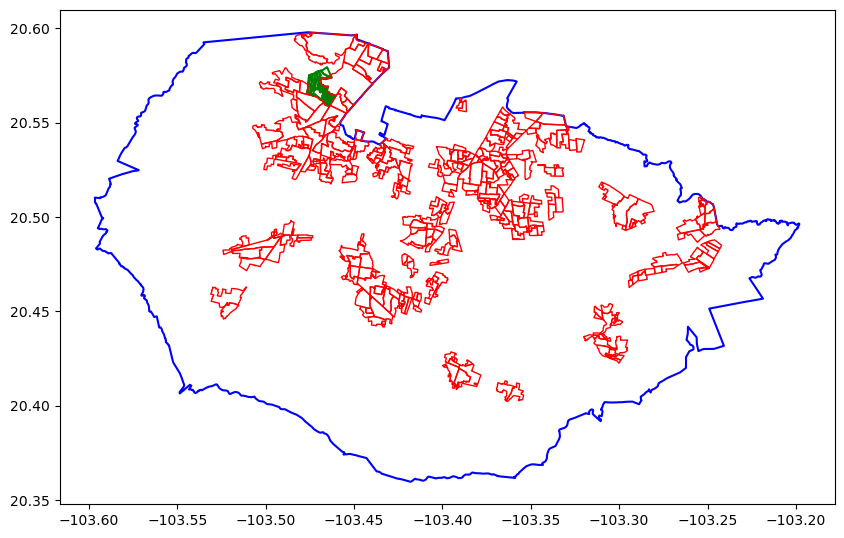

In [46]:
CVE_MUN = case_1.CVE_MUN.unique()[0]

case_1_mun = city_gdf.loc[city_gdf.CVE_MUN == CVE_MUN].copy()
case_1_mun_agebs = pop_ageb_gdf.loc[pop_ageb_gdf.CVE_MUN == CVE_MUN].copy()

# Show
fig, ax = plt.subplots(figsize=(10, 10))

case_1_mun_agebs.plot(ax=ax, edgecolor="red",color='none',zorder=3)
case_1.boundary.plot(ax=ax, color="green",zorder=2)
case_1_mun.boundary.plot(ax=ax, edgecolor="blue",zorder=1)

#### Caso 2 AGEB 1467, appears as AMBITO == 'Rural' in pop_mza_gdf

In [47]:
case_2 = pop_mza_gdf.loc[pop_mza_gdf.CVE_AGEB == '1467'].copy()

print(case_2.POBTOT.sum())
print(case_2.AMBITO.unique())
case_2.head(1)

19353
['Urbana' 'Rural']


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
186,1403900011467001,14,039,0001,1467,001,Urbana,Típica,"POLYGON ((-103.29976 20.67129, -103.29970 20.6...",14,...,9,16,7,6,None,0,0,0,10,0


In [48]:
case_2_urb = case_2.loc[case_2.AMBITO == 'Urbana'].copy()
case_2_rur = case_2.loc[case_2.AMBITO == 'Rural'].copy()

<Axes: >

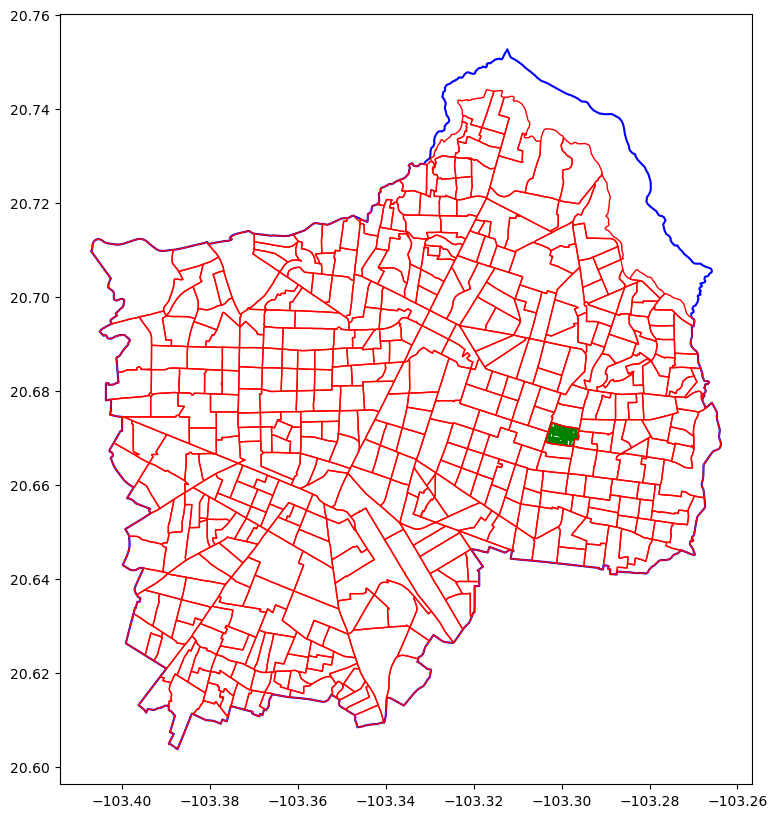

In [49]:
CVE_MUN_2 = case_2_urb.CVE_MUN.unique()[0]

case_2_mun = city_gdf.loc[city_gdf.CVE_MUN == CVE_MUN_2].copy()
case_2_mun_agebs = pop_ageb_gdf.loc[pop_ageb_gdf.CVE_MUN == CVE_MUN_2].copy()

# Show
fig, ax = plt.subplots(figsize=(10, 10))

case_2_mun_agebs.plot(ax=ax, edgecolor="red",color='none',zorder=3)
case_2_urb.boundary.plot(ax=ax, color="green",zorder=2)
case_2_mun.boundary.plot(ax=ax, edgecolor="blue",zorder=1)

<Axes: >

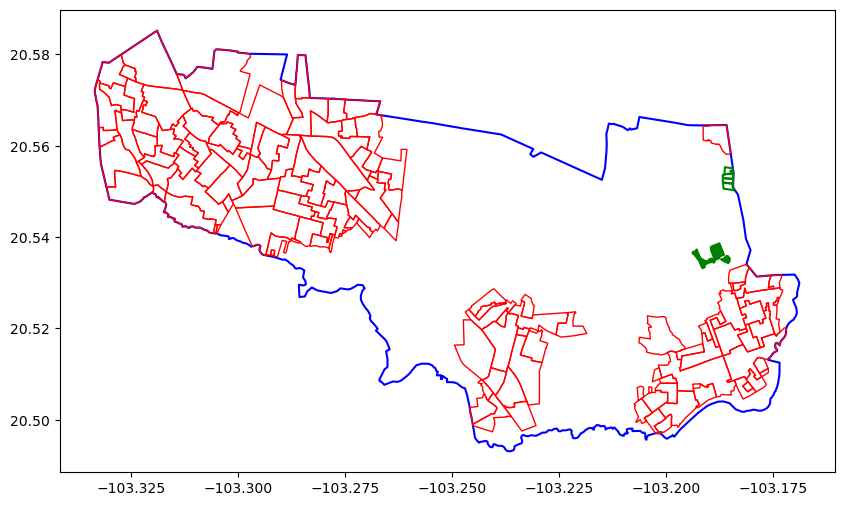

In [50]:
CVE_MUN_2 = case_2_rur.CVE_MUN.unique()[0]

case_2_mun = city_gdf.loc[city_gdf.CVE_MUN == CVE_MUN_2].copy()
case_2_mun_agebs = pop_ageb_gdf.loc[pop_ageb_gdf.CVE_MUN == CVE_MUN_2].copy()

# Show
fig, ax = plt.subplots(figsize=(10, 10))

case_2_mun_agebs.plot(ax=ax, edgecolor="red",color='none',zorder=3)
case_2_rur.boundary.plot(ax=ax, color="green",zorder=2)
case_2_mun.boundary.plot(ax=ax, edgecolor="blue",zorder=1)

In [51]:
case_2.POBTOT.sum()

19353

In [52]:
case_2_urb.POBTOT.sum()

4745

In [53]:
case_2_rur.POBTOT.sum()

14608

In [54]:
pop_ageb_gdf.loc[pop_ageb_gdf.CVE_AGEB == '1467'].POBTOT.sum()

4745

### __Conclusión: Sí hay que quitar el AMBITO == 'Rural'__, por alguna razón ese AGEB rural con 14,000 personas se coló de otro municipio.

### Entonces, ¿Por qué hay más AGEBs en pop_mza_gdf (1600 vs 1599) pero menos población (4,997,347 vs 4,997,967)?

In [55]:
city_gdf.head(1)

pop_ageb_gdf = gpd.GeoDataFrame()
pop_mza_gdf = gpd.GeoDataFrame()

# Load ents
cve_ent_list = list(city_gdf.CVE_ENT.unique())
for cve_ent in cve_ent_list:

    #Load muns in each ent
    cve_mun_list = list(city_gdf.loc[city_gdf.CVE_ENT == cve_ent].CVE_MUN.unique())

    # Load AGEBs and concat
    query = f"SELECT * FROM censoageb.censoageb_{year} WHERE (\"cve_ent\" = \'{cve_ent}\') AND \"cve_mun\" IN {str(tuple(cve_mun_list))} "
    pop_ageb_gdf = pd.concat([pop_ageb_gdf,aup.gdf_from_query(query, geometry_col='geometry')])

    # load Blocks and concat
    query = f"SELECT * FROM censo_mza.censo_mza_{year} WHERE (\"CVE_ENT\" = \'{cve_ent}\') AND \"CVE_MUN\" IN {str(tuple(cve_mun_list))} "
    pop_mza_gdf = pd.concat([pop_mza_gdf,aup.gdf_from_query(query, geometry_col='geometry')])
    if year == '2020':
        pop_mza_gdf = pop_mza_gdf.loc[pop_mza_gdf.AMBITO == 'Urbana'].copy()

# Show
print(f'AGEBs en pop_ageb_gdf: {len(pop_ageb_gdf.cve_ageb.unique())}.')
print(f'POBTOT en pop_ageb_gdf: {pop_ageb_gdf.pobtot.sum()}.')

print(f'AGEBs en pop_mza_gdf: {len(pop_mza_gdf.CVE_AGEB.unique())}.')
print(f'POBTOT en pop_mza_gdf: {pop_mza_gdf.POBTOT.sum()}.')

AGEBs en pop_ageb_gdf: 1599.
POBTOT en pop_ageb_gdf: 4997967.
AGEBs en pop_mza_gdf: 1600.
POBTOT en pop_mza_gdf: 4997347.


In [56]:
# --------------- 1.1 SET COLUMNS TO .UPPER() EXCEPT FOR GEOMETRY
# (When the equations were written, we used UPPER names, easier to change it this way and then return output with .lower columns)
pop_ageb_gdf.columns = pop_ageb_gdf.columns.str.upper()
pop_ageb_gdf.rename(columns={'GEOMETRY':'geometry'},inplace=True)

pop_mza_gdf.columns = pop_mza_gdf.columns.str.upper()
pop_mza_gdf.rename(columns={'GEOMETRY':'geometry'},inplace=True)

In [63]:
len(pop_ageb_gdf.CVE_AGEB.unique())

1599

In [64]:
len(pop_mza_gdf.CVE_AGEB.unique())

1600

In [74]:
for mun in list(pop_ageb_gdf.CVE_MUN.unique()):
    mun_ageb_gdf = pop_ageb_gdf.loc[pop_ageb_gdf.CVE_MUN == mun].copy()
    mun_mza_gdf = pop_mza_gdf.loc[pop_mza_gdf.CVE_MUN == mun].copy()

    pop_mun_ageb_gdf = mun_ageb_gdf.POBTOT.sum()
    pop_mun_mza_gdf = mun_mza_gdf.POBTOT.sum()
    
    print(city_gdf.loc[city_gdf.CVE_MUN == mun].NOMGEO.unique()[0])
    print(f"Población en ageb_gdf: {pop_mun_ageb_gdf}.")
    print(f"Población en mza_gdf: {pop_mun_mza_gdf}.")
    print(f"__Diff: {pop_mun_ageb_gdf-pop_mun_mza_gdf}.__")
    print("--"*20)

Guadalajara
Población en ageb_gdf: 1385621.
Población en mza_gdf: 1385606.
__Diff: 15.__
----------------------------------------
Juanacatlán
Población en ageb_gdf: 26261.
Población en mza_gdf: 26200.
__Diff: 61.__
----------------------------------------
El Salto
Población en ageb_gdf: 211141.
Población en mza_gdf: 211022.
__Diff: 119.__
----------------------------------------
Tlajomulco de Zúñiga
Población en ageb_gdf: 686510.
Población en mza_gdf: 687751.
__Diff: -1241.__
----------------------------------------
San Pedro Tlaquepaque
Población en ageb_gdf: 678905.
Población en mza_gdf: 678372.
__Diff: 533.__
----------------------------------------
Tonalá
Población en ageb_gdf: 560074.
Población en mza_gdf: 559383.
__Diff: 691.__
----------------------------------------
Zapopan
Población en ageb_gdf: 1449455.
Población en mza_gdf: 1449013.
__Diff: 442.__
----------------------------------------


In [82]:
pop_mza_gdf.head(1)

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,140390001418A052,14,039,0001,418A,052,Urbana,Típica,"POLYGON ((-103.28446 20.69343, -103.28485 20.6...",14,...,26,76,66,40,32,21,None,0,8,0


### __Conclusión hasta ahora:__
### __> Integrar nueva manera de querry (CVEs tupples) al script__
### __> Dejar el filtrado para quitar AMBITO == 'Rural'__
### __> Dejar el chequeo de diferencias de AGEBs en calculate_censo_nan_values_v1, pero no eliminar todos los AGEBs. Más bien:__
### __>>> Si está en mza_gdf, pero no en ageb_gdf, realizar primer parte de calculate_censo_nan_values (Sumar columnas de mza_gdf, pero sacar del llenado con ageb)
### __>>> Si está en ageb_gdf, pero no en mza_gdf, saltar para evitar crash (TRY, EXCEPT)